In [29]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

#### Get audio vector and inital tempo estimation

In [5]:
path = '../audio/money-pink-floyd-hd-studio-version_02.mp3'
loader = estd.AudioLoader(filename=path)
downmixer = estd.MonoMixer()
tempAudioInput, fs, numb_channels, md5, bit_rate, codec = loader()
audioInput = downmixer(tempAudioInput, numb_channels)
tempo_estimation_algo = estd.PercivalBpmEstimator(sampleRate=int(fs))
bpm = tempo_estimation_algo(audioInput)
print(bpm)

125.28408813476562


#### Compute spectrogram and 2-band energy

In [6]:
## var init
frame_size = 1024
hop_size = 512
fft_size = 1024

## get necessary Essentia algorithms
window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann')
fft_algo = estd.FFT(size = fft_size)

spectrogram = []
db_spectrogram = []
print('Frame Size:', frame_size)
print('FFT Size:', fft_size)

for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
    ## spectrogram
    windowed_frame = window_algo(frame)
    mX = abs(fft_algo(windowed_frame))
    mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
    dbX = 20 * np.log10(mX)
    spectrogram.append(np.array(mX))
    db_spectrogram.append(np.array(dbX))
    
spectrogram = np.array(spectrogram)
db_spectrogram = np.array(db_spectrogram)
print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)

Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (1037, 513)


#### Plot Spectrogram (for visual feedback only)

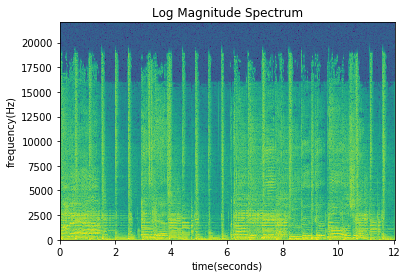

In [7]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [24]:
# beat estimation
beatTracker = estd.BeatTrackerDegara()
beats = beatTracker(audioInput)
beats_frames = [int(bf) for bf in (beats * fs / hop_size)]
print(beats)

print(beats_frames)

[  0.51083899   1.033288     1.53251696   2.02013612   2.49614501
   2.97215414   3.45977306   3.94739223   4.43501139   4.91102028
   5.38702917   5.85142851   6.3274374    6.8150568    7.31428576
   7.79029465   8.27791405   8.75392246   9.22993183   9.7059412
  10.19355965  10.68117905  11.15718842  11.63319683]
[44, 89, 132, 174, 214, 256, 297, 340, 382, 423, 463, 504, 545, 587, 630, 671, 713, 753, 795, 836, 877, 920, 961, 1001]


In [53]:
# for i in range(len(beats)-1):
#     dur_beats.append(beats[i+1] - beats[i])
#     pc8_dur_beats.append(dur_beats[i] * 0.08)

# avDur = np.average(dur_beats)
# avDurInFrames = int(avDur * fs / hop_size)
# avDur8 = np.average(pc8_dur_beats)
# avDur8InFrames = int(avDur8 * fs / hop_size)
# print(avDurInFrames)
# print(avDur8InFrames)

# framePosBeat = []
beats_neighbour_spect = {}
i = 0

while i <= len(beats_frames)-1:
    if i != len(beats_frames)-1:
        beat_duration = beats_frames[i+1] - beats_frames[i]
    duration_8_percent = int(beat_duration*0.08)
    beats_neighbour_spect[beats_frames[i]] = spectrogram[beats_frames[i]-duration_8_percent:beats_frames[i]+duration_8_percent]
    i += 1

ASM_dict = {}
for beat_x in beats_neighbour_spect:
    ASM_dict[beat_x] = {}
    for beat_y in beats_neighbour_spect:
        temp_ASM = cdist(beats_neighbour_spect[beat_x], beats_neighbour_spect[beat_y], metric='euclidean')
        ASM_dict[beat_x][beat_y] = temp_ASM

In [54]:
print(len(beats_frames))

24


In [ ]:
plt.matshow(ASM)

In [56]:
print(len(ASM_dict))
print(len(ASM_dict[44]))

24
24


In [ ]:
M = [[]]
for frames in framesXbeat:
    #print(frames)
    w, h = frames[0], frames[1]
    M = [[0] * w for i in range(h)]
    for i in range(frames[0], frames[1]):
        #print(str(i) + ", " + str(frames[0]))
        #print(spectrogram[frames[0]])
        #print(euclidean(spectrogram[frames[0]],spectrogram[i]))
        M[frames[0]][i] = euclidean(spectrogram[frames[0]],spectrogram[i])
    
    


plt.matshow(A)  
#print(A)

In [ ]:
ASM = squareform(pdist(spectrogram))
plt.matshow(ASM)

In [10]:
w, h = spectrogram.shape[0], spectrogram.shape[0]
ASM = [[1] * w for i in range(h)]

for position in framePosBeat:
    for i in range(avDurInFrames):
        
        for other in framePosBeat:
            for j in range(avDurInFrames):
                for k in range(avDur8InFrames):
                    euclidean(spectrogram[i],spectrogram[j-k])
                    if k is not 0:
                        euclidean(spectrogram[i],spectrogram[j+k])


for framesBeat in framesXbeat:
    for i in range(framesBeat[0], framesBeat[1]):
        for frame in framesXbeat:
            for j in range(frame[0], frame[1]):
                ASM[i][j] = euclidean(spectrogram[i],spectrogram[j])


NameError: name 'framesXbeat' is not defined

In [ ]:
ref_ASM = squareform(pdist(spectrogram))

In [ ]:
labels = list(range(int(len(audioInput)/fs)))
plt.matshow(ref_ASM[::-1])
stride = list(np.multiply(fs/hop_size, labels))
plt.xticks(stride, labels)
plt.yticks(stride, labels[::-1])
plt.grid(True)

In [ ]:
bar_candidates = np.multiply(64, list(range(2, 13)))

In [ ]:
def segment_diagonal(diagonal, bar_length):
    return [diagonal[i:i+bar_length] for i in range(0, len(diagonal), bar_length)]

In [ ]:
diagonals = {}
SCS = {}
SM = {}
for bar in bar_candidates:
    diagonals[bar] = {}
    numb_diagonals = int(ref_ASM.shape[0]/bar)
    for i in range(1, numb_diagonals):
        diagonals[bar][i] = list(np.diagonal(ref_ASM, bar*i))
        diagonals[bar][i] = segment_diagonal(diagonals[bar][i], bar)
    SCS[bar] = {}
    for diagonal in range(1, numb_diagonals):
        SCS[bar][diagonal] = []
        for segment in diagonals[bar][diagonal]:
            SCS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
    SM[bar] = None
    scsi = 0
    sisi = 0
    sc = 0
    si = 0
    if len(diagonals[bar]) is 0:
        r = 0
    else: 
        r = len(diagonals[bar][1][-1])
    for diagonal in range(1, numb_diagonals):
        #for scs in SCS[bar][diagonal]:
        #print(SCS[bar][diagonal][-1])
        scsi += sum(SCS[bar][diagonal][:-1])
        sisi += SCS[bar][diagonal][-1]
        sc += len(SCS[bar][diagonal][:-1])
        si += 1
    SM[bar] = (bar*scsi + r*sisi)/(bar*sc + r*si) 

# plt.plot(range(2, 12), SM)
print(SM)
        

In [ ]:
plt.bar(range(len(SM)), list(SM.values()), align='center')
plt.xticks(range(len(SM)), list(list(SM.keys())))

In [ ]:
a = [0,1,2,3]
a.append(4)
a.insert(0, -1)

In [ ]:
a